# Tree Ensemble

### In this notebook, I will study the implementation of Decision Tree, Random Forest and XGBoost models using scikit-learn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier

RANDOM_STATE = 55 # I will pass it to every sklearn call so I ensure reproducibility

# Dataset

The dataset is obtained from: [Heart Failure Prediction Dataset](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction)

This dataset contains 11 features that can be used to predict possible heart disease.

#### Attribute Information
- Age: age of the patient [years]
- Sex: sex of the patient [M: Male, F: Female]
- ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- RestingBP: resting blood pressure [mm Hg]
- Cholesterol: serum cholesterol [mm/dl]
- FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
- ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
- Oldpeak: oldpeak = ST [Numeric value measured in depression]
- ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- HeartDisease: output class [1: heart disease, 0: Normal]

Let's now load the dataset. As we can see above, the variables:

- Sex
- ChestPainType
- RestingECG
- ExerciseAngina
- ST_Slope

Are *categorical*, so we must one-hot encode them. 

In [2]:
# Load the dataset

In [3]:
df = pd.read_csv("data/Heart_Disease/heart.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Performing some data engineering before working with the models. I will use Pandas to one-hot encode the categorical features.

## One-hot encoding

In [4]:
cat_variables = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

In [5]:
df = pd.get_dummies(data = df, prefix = cat_variables, columns = cat_variables)          # pd.get_dummies: Convert categorical data into dummy/indicator variables.
df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,1,0,0,...,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,0,1,0,...,0,0,0,0,1,1,0,0,0,1
3,48,138,214,0,108,1.5,1,1,0,1,...,0,0,0,1,0,0,1,0,1,0
4,54,150,195,0,122,0.0,0,0,1,0,...,1,0,0,1,0,1,0,0,0,1


The target is `HeartDisease`

In [6]:
features = [x for x in df.columns if x not in 'HeartDisease']       # Removing the target variable
features

['Age',
 'RestingBP',
 'Cholesterol',
 'FastingBS',
 'MaxHR',
 'Oldpeak',
 'Sex_F',
 'Sex_M',
 'ChestPainType_ASY',
 'ChestPainType_ATA',
 'ChestPainType_NAP',
 'ChestPainType_TA',
 'RestingECG_LVH',
 'RestingECG_Normal',
 'RestingECG_ST',
 'ExerciseAngina_N',
 'ExerciseAngina_Y',
 'ST_Slope_Down',
 'ST_Slope_Flat',
 'ST_Slope_Up']

In [7]:
print(len(features))

20


# Splitting the Dataset

In [8]:
X_train, X_val, y_train, y_val = train_test_split(df[features], df['HeartDisease'], train_size = 0.8, random_state=RANDOM_STATE)

In [9]:
print(f'Train samples: {len(X_train)}')
print(f'Validation samples: {len(X_val)}')
print(f'Target proportion: {sum(y_train)/len(y_train):.4f}')

Train samples: 734
Validation samples: 184
Target proportion: 0.5518


I am going to build a Decision Tree using the [Scikit-learn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

The hyperparameters that I will use are:
- min_samples_split: The minimum number of samples required to split an initernal node.
    - Choosing a higher min_samples_split can reduce the number of splits and may help to reduce overfitting.
- max_depth: The maximum depth of the three.
    - Choosing a lower max_depth can reduce the number splits and may help to reduce overfitting.

In [10]:
min_samples_split_list = [2, 10, 30, 50, 100, 200, 300, 700] ## If the number is an integer, then it is the actual quantity of samples
max_depth_list = [1, 2, 3, 4, 8, 16, 32, 64, None] # None means that there is no depth limit

In [11]:
print(type(min_samples_split_list))
print(min_samples_split_list)

<class 'list'>
[2, 10, 30, 50, 100, 200, 300, 700]


In [12]:
accuracy_list_train = []
accuracy_list_val = []

for min_samples_split in min_samples_split_list:
    # Note: You can fit the model at the same time you define it, because the fit function returns the fitted estimator
    model = DecisionTreeClassifier(min_samples_split = min_samples_split, random_state = RANDOM_STATE).fit(X_train, y_train)
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train, y_train)
    accuracy_val = accuracy_score(predictions_val, y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

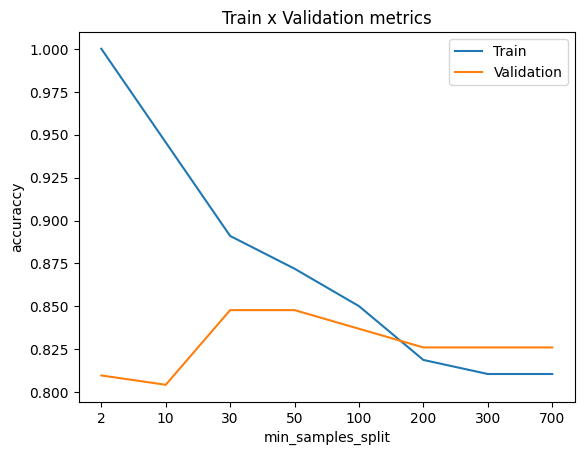

In [13]:
plt.title('Train x Validation metrics')
plt.xlabel('min_samples_split')
plt.ylabel('accuraccy')
plt.xticks(ticks = range(len(min_samples_split_list)),labels=min_samples_split_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train', 'Validation'])


Note how increasing the number of `min_samples_split` reduce the overfitting.

-   Increasing `min_samples_split` from 10 to 30, and from 30 to 50, even though it does  not improve the validation accuracy, it brings the training accurracy closer to it, showing a reduction in overfitting.

Let's do the same with `max_depth`.]

In [14]:
accuracy_list_train = []
accuracy_list_val = []

for max_depth in max_depth_list:
    # Note: You can fit the model at the same time you define it, because the fit function returns the fitted estimator
    model = DecisionTreeClassifier(max_depth = max_depth, random_state = RANDOM_STATE).fit(X_train, y_train)
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train, y_train)
    accuracy_val = accuracy_score(predictions_val, y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

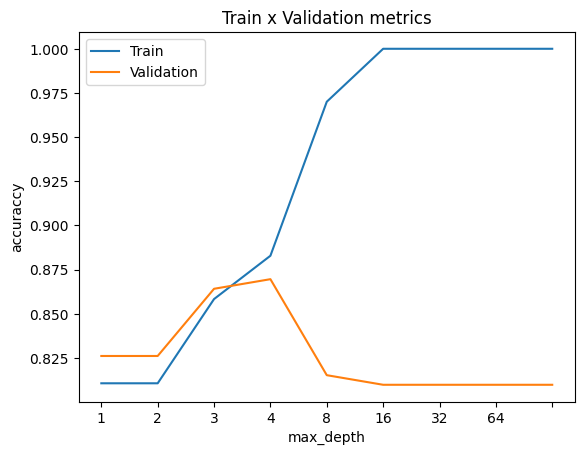

In [15]:
plt.title('Train x Validation metrics')
plt.xlabel('max_depth')
plt.ylabel('accuraccy')
plt.xticks(ticks = range(len(max_depth_list)),labels=max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train', 'Validation'])

We can see that in general, reducing `max_depth` can help to reduce overfitting.
- Reducing `max_depth` from 8 to 4 increases validation accuracy closer to training accuracy, while significantly reducing training accuraccy.
- The validation accuracy reaches the highest at tree_depth=4. 
- When the `max_depth` is smaller than 3, both training and validation accuracy decreases.  The tree cannot make enough splits to distinguish positives from negatives (the model is underfitting the training set). 
- When the `max_depth` is too high ( >= 5), validation accuracy decreases while training accuracy increases, indicating that the model is overfitting to the training set.

So we can choose the best values for these two hyper-parameters for our model to be:
- `max_depth = 4`
- `min_samples_split = 50` 

In [16]:
decision_tree_model = DecisionTreeClassifier(min_samples_split = 50, max_depth = 3, random_state = RANDOM_STATE).fit(X_train, y_train)

In [17]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(X_train),y_train):.4f}")
print(f"Metrics validation:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(X_val),y_val):.4f}")

Metrics train:
	Accuracy score: 0.8583
Metrics validation:
	Accuracy score: 0.8641


# Random Forest

Let's try the Random Forest algorithm.

In [18]:
min_samples_split_list = [2, 10, 30, 50, 100, 200, 300, 700]

max_depth_list = [2, 4, 8, 16, 32, 64, None]

n_estimators_list = [10, 50, 100, 500]  # The number of Decision Trees that make up the Random Forest.

In [19]:
accuracy_list_train = []
accuracy_list_val = []

for min_samples_split in min_samples_split_list:
    model = RandomForestClassifier(min_samples_split = min_samples_split, random_state = RANDOM_STATE).fit(X_train, y_train)
    predictions_train = model.predict(X_train)
    predictions_val = model.predict(X_val)
    accuracy_train = accuracy_score(predictions_train, y_train)
    accuracy_val = accuracy_score(predictions_val, y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

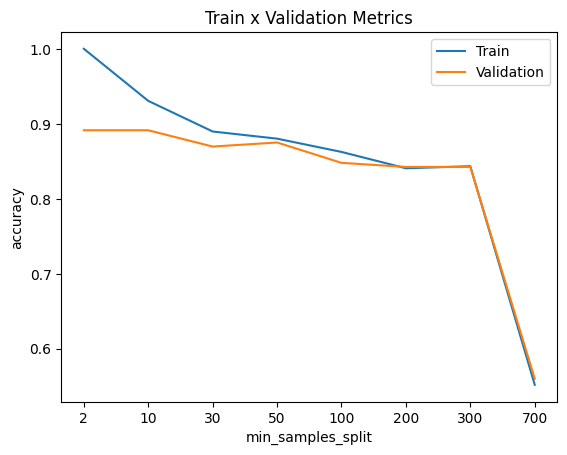

In [20]:
plt.title('Train x Validation Metrics')
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(min_samples_split_list)), labels = min_samples_split_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train', 'Validation'])

Notice that, even though the validation accuracy reached is the same both at `min_samples_split = 2` and `min_samples_split = 10`, in the latter the difference in training and validation set reduces, showing less overfitting.

In [21]:
accuracy_list_train = []
accuracy_list_val = []

for max_depth in max_depth_list:
    model = RandomForestClassifier(max_depth = max_depth, random_state = RANDOM_STATE).fit(X_train, y_train)
    predictions_train = model.predict(X_train)
    predictions_val = model.predict(X_val)
    accuracy_train = accuracy_score(predictions_train, y_train)
    accuracy_val = accuracy_score(predictions_val, y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

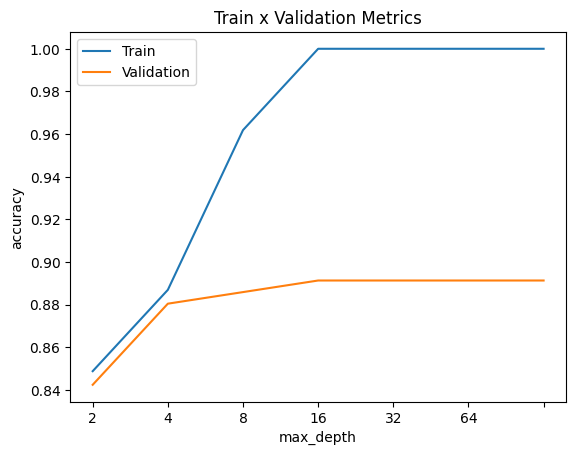

In [22]:
plt.title('Train x Validation Metrics')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_list)), labels = max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train', 'Validation'])

In [23]:
accuracy_list_train = []
accuracy_list_val = []

for n_estimators in n_estimators_list:
    model = RandomForestClassifier(n_estimators = n_estimators, random_state = RANDOM_STATE).fit(X_train, y_train)
    predictions_train = model.predict(X_train)
    predictions_val = model.predict(X_val)
    accuracy_train = accuracy_score(predictions_train, y_train)
    accuracy_val = accuracy_score(predictions_val, y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

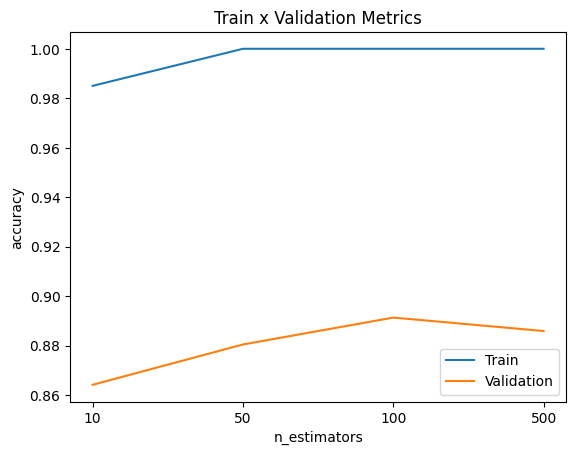

In [24]:
plt.title('Train x Validation Metrics')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(n_estimators_list)), labels = n_estimators_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train', 'Validation'])

Let's fit a random forest with the following parameters:
- max_depth = 16
- min_samples_split = 10
- n_estimators = 100

In [25]:
random_forest_model = RandomForestClassifier(n_estimators = 100, max_depth = 16, min_samples_split = 10).fit(X_train, y_train)

In [26]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(random_forest_model.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score:{accuracy_score(random_forest_model.predict(X_val),y_val):.4f}")

Metrics train:
	Accuracy score: 0.9346
Metrics test:
	Accuracy score:0.8913


Note that we are searching for the best value one hyperparameter while leaving the other hyperparameters at their default values.
- Ideally, we would want to check every combination of values for every hyperparameter that we are tuning.
- If we have 3 hyperparameters, and each hyperparameter has 4 values to try out, we should have a total of 4 x 4 x 4 = 64 combinations to try.
- When we only modify one hyperparameter while leaving the rest as their default value, we are trying 4 + 4 + 4 = 12 results. 
- To try out all combinations, we can use a sklearn implementation called GridSearchCV. GridSearchCV has a refit parameter that will automatically refit a model on the best combination so we will not need to program it explicitly. For more on GridSearchCV, please refer to its [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

# XGBoost

This model has te same parameters as the decision tree, plus the learning rate.

- The learning rate is the size of the step on the Gradient Descent method that the XGBoost uses internally to minimize the error on each train step.

Let's define a subset of our training set.

In [27]:
n = int(len(X_train)*0.8) # 80% train, 20% to eval.

In [28]:
X_train_fit, X_train_eval, y_train_fit, y_train_eval = X_train[:n], X_train[n:], y_train[:n], y_train[n:]

In [29]:
#xgb_model = XGBClassifier(n_estimators = 500, learning_rate = 0.1, verbosity = 1, random_state = RANDOM_STATE, early_stopping_rounds=10)
#xgb_model.fit(X_train_fit, y_train_fit, eval_set = [(X_train_eval, y_train_eval)])

xgb_model = XGBClassifier(n_estimators = 500, learning_rate = 0.1,verbosity = 1, random_state = RANDOM_STATE, early_stopping_rounds = 10)
xgb_model.fit(X_train_fit,y_train_fit, eval_set = [(X_train_eval,y_train_eval)])

[0]	validation_0-logloss:0.63301
[1]	validation_0-logloss:0.59553
[2]	validation_0-logloss:0.56612
[3]	validation_0-logloss:0.54186
[4]	validation_0-logloss:0.52348
[5]	validation_0-logloss:0.50610
[6]	validation_0-logloss:0.49371
[7]	validation_0-logloss:0.48365
[8]	validation_0-logloss:0.47321
[9]	validation_0-logloss:0.46537
[10]	validation_0-logloss:0.45999
[11]	validation_0-logloss:0.45620
[12]	validation_0-logloss:0.45482
[13]	validation_0-logloss:0.44974
[14]	validation_0-logloss:0.44494
[15]	validation_0-logloss:0.44072
[16]	validation_0-logloss:0.44078
[17]	validation_0-logloss:0.43935
[18]	validation_0-logloss:0.44206
[19]	validation_0-logloss:0.44536
[20]	validation_0-logloss:0.44321
[21]	validation_0-logloss:0.44310
[22]	validation_0-logloss:0.44419
[23]	validation_0-logloss:0.44797
[24]	validation_0-logloss:0.44843
[25]	validation_0-logloss:0.45337
[26]	validation_0-logloss:0.45206
[27]	validation_0-logloss:0.45435


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, ...)

Even though I initialized the model to allow up to 500 estimators, the algoritm only fit 27 estimators. Too see why, let's look for the round of training that had the best performance (lowest evaluation metric)

In [30]:
xgb_model.best_iteration

17

The best round of training was round 17, with a log loss of 0.43935

In [31]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_val),y_val):.4f}")

Metrics train:
	Accuracy score: 0.9319
Metrics test:
	Accuracy score: 0.8533


In this case, both Random Forest and XGBoost had a similar performance (test accuracy).